# Sampling Methods #
## Joon Yuhl Soh ##

With the CHD data set (CHDdata.csv ) from Homework 2 develop a
sampling based estimate for the posterior distributions of the parameters
in a main effects logistic regression model. Use all predictor variables
in the data set and standardize all of the numeric, continuous predictors
using the mean and standard deviation.


• Use Gaussian or Cauchy priors with hyperparameters appropriate
for uninformed priors and show the graphical representation of your
model (you should use graphviz for this).


• Show the summary table and trace plots from the sampling and
briefly say what they mean for your results.


• Provide forest plots of the parameters and discuss what these results
imply for the relevant predictor variables and the overall model.


In [1]:
import numpy as np
import scipy.stats as st
import scipy.linalg as la
import matplotlib.pyplot as pp
import pandas as pd
import pymc3 as pm
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import arviz as az
import seaborn as sns
import theano.tensor as tt
%matplotlib inline
pp.style.use('seaborn-darkgrid')

In [2]:
data_c = pd.read_csv("CHDdata.csv")
data_c.head(5)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


Fist, make sure categorical values are recorded properly

In [3]:
replace_map = {
    'famhist':{
        'Absent':-1,
        'Present':1
    },
    'chd':{
        1:0.9999,
        0:0.0001
    }
}
data_c = data_c.replace(replace_map)
data_c.head(5)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,0.9999
1,144,0.01,4.41,28.61,-1,55,28.87,2.06,63,0.9999
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0.0001
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,0.9999
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,0.9999


Then make sure other colums are also standardized. 

In [4]:
numCols = ['sbp', 'tobacco', 'ldl', 'adiposity','typea','obesity','alcohol','age']
for i in numCols :
    data_c[i] = (data_c[i] - data_c[i].mean()) / data_c[i].std()
data_c.head(5)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.057417,1.821099,0.477894,-0.295183,1,-0.418017,-0.176594,3.274189,0.628654,0.9999
1,0.276789,-0.789382,-0.159507,0.411694,-1,0.193134,0.670646,-0.612081,1.381617,0.9999
2,-0.991731,-0.774141,-0.608585,0.883374,1,-0.112441,0.734723,-0.540597,0.217947,0.0001
3,1.545310,0.841352,0.806252,1.622382,1,-0.214300,1.411091,0.294742,1.039361,0.9999
4,-0.211103,2.169453,-0.598928,0.305020,1,0.702427,-0.012842,1.645991,0.423301,0.9999


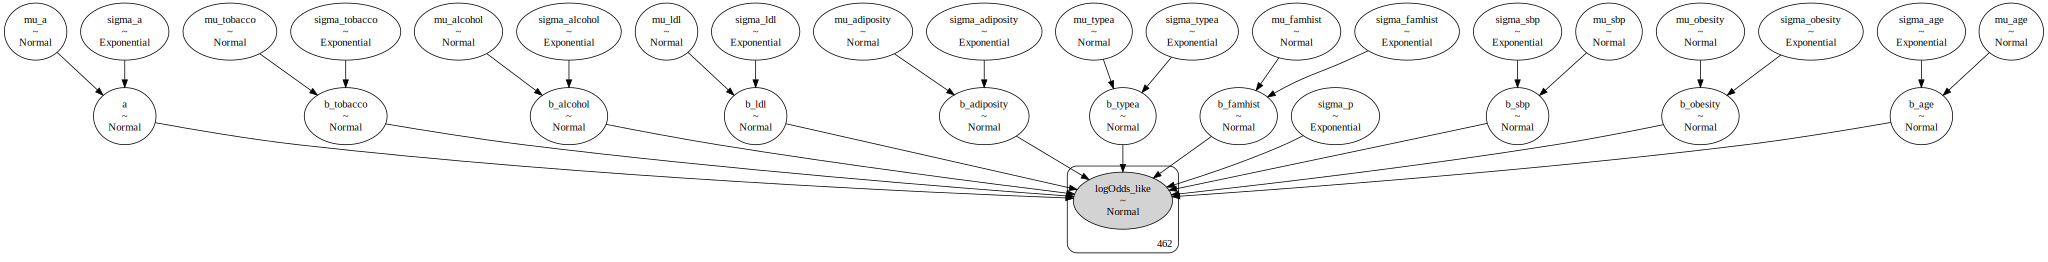

In [5]:
with Model() as varying_logOdds:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=9999)
    sigma_a = pm.Exponential("sigma_a", 1)
    
    mu_sbp = pm.Normal('mu_sbp', mu=0, sd=9999)
    sigma_sbp = pm.Exponential("sigma_sbp", 1)
    
    mu_tobacco = pm.Normal('mu_tobacco', mu=0, sd=9999)
    sigma_tobacco = pm.Exponential("sigma_tobacco", 1)
    
    mu_ldl = pm.Normal('mu_ldl', mu=0, sd=9999)
    sigma_ldl = pm.Exponential("sigma_ldl", 1)
    
    mu_adiposity = pm.Normal('mu_adiposity', mu=0, sd=9999)
    sigma_adiposity = pm.Exponential("sigma_adiposity", 1)
    
    mu_famhist = pm.Normal('mu_famhist', mu=0, sd=9999)
    sigma_famhist = pm.Exponential("sigma_famhist", 1)
    
    mu_typea = pm.Normal('mu_typea', mu=0, sd=9999)
    sigma_typea = pm.Exponential("sigma_typea", 1)
    
    mu_obesity = pm.Normal('mu_obesity', mu=0, sd=9999)
    sigma_obesity = pm.Exponential("sigma_obesity", 1)
    
    mu_alcohol = pm.Normal('mu_alcohol', mu=0, sd=9999)
    sigma_alcohol = pm.Exponential("sigma_alcohol", 1)
    
    mu_age = pm.Normal('mu_age', mu=0, sd=9999)
    sigma_age = pm.Exponential("sigma_age", 1)
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a)
    # Random slopes
    b_sbp = pm.Normal('b_sbp', mu=mu_sbp, sd=sigma_sbp)
    b_tobacco = pm.Normal('b_tobacco', mu=mu_tobacco, sd=sigma_tobacco)
    b_ldl = pm.Normal('b_ldl', mu=mu_ldl, sd=sigma_ldl)
    b_adiposity = pm.Normal('b_adiposity', mu=mu_adiposity, sd=sigma_adiposity)
    b_famhist = pm.Normal('b_famhist', mu=mu_famhist, sd=sigma_famhist)
    b_typea = pm.Normal('b_typea', mu=mu_typea, sd=sigma_typea)
    b_obesity = pm.Normal('b_obesity', mu=mu_obesity, sd=sigma_obesity)
    b_alcohol = pm.Normal('b_alcohol', mu=mu_alcohol, sd=sigma_alcohol)
    b_age = pm.Normal('b_age', mu=mu_age, sd=sigma_age)
    
    # Expected value
    logOdds_hat = a + b_sbp * data_c.sbp.values + b_tobacco * data_c.tobacco.values + b_ldl * data_c.ldl.values + b_adiposity * data_c.adiposity.values + b_famhist * data_c.famhist.values + b_typea * data_c.typea.values + b_obesity * data_c.obesity.values + b_alcohol * data_c.alcohol.values + b_age * data_c.age.values
    
    sigma_p = pm.Exponential("sigma_p", 1)
    logOdds_true = tt.log(data_c.chd.values / (1 - data_c.chd.values))
    
    # Data likelihood
    logOdds_like = pm.Normal('logOdds_like', mu=logOdds_hat, sd=sigma_p, observed=logOdds_true)

pm.model_to_graphviz(varying_logOdds)

In [6]:
with varying_logOdds:
    varying_logOdds_trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000)
    varying_logOdds_idata = az.from_pymc3(varying_logOdds_trace)
az.summary(varying_logOdds_idata, round_to=2)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_p, b_age, b_alcohol, b_obesity, b_typea, b_famhist, b_adiposity, b_ldl, b_tobacco, b_sbp, a, sigma_age, mu_age, sigma_alcohol, mu_alcohol, sigma_obesity, mu_obesity, sigma_typea, mu_typea, sigma_famhist, mu_famhist, sigma_adiposity, mu_adiposity, sigma_ldl, mu_ldl, sigma_tobacco, mu_tobacco, sigma_sbp, mu_sbp, sigma_a, mu_a]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 1922 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,-2.50,1.50,-5.48,0.39,0.05,0.04,955.89,749.77,1279.65,895.52,1.01
mu_sbp,0.50,1.29,-2.12,2.98,0.03,0.03,1534.45,998.14,1942.64,997.04,1.01
mu_tobacco,1.31,1.36,-1.10,4.20,0.04,0.03,1183.63,983.03,1549.55,951.54,1.00
mu_ldl,1.24,1.51,-1.85,3.93,0.05,0.04,923.86,793.01,1462.32,915.06,1.00
mu_adiposity,0.37,1.52,-2.28,3.22,0.05,0.04,853.89,664.63,1141.79,1050.55,1.01
mu_famhist,1.59,1.39,-1.01,4.59,0.04,0.03,994.99,968.16,1391.77,1052.86,1.00
mu_typea,1.14,1.40,-1.68,3.67,0.04,0.03,1208.41,861.84,1598.26,1026.24,1.00
mu_obesity,-0.91,1.35,-3.46,1.64,0.04,0.03,1306.44,1087.28,1564.05,1282.48,1.00
mu_alcohol,-0.04,1.54,-3.25,2.92,0.05,0.05,888.68,581.15,1320.81,835.07,1.00
mu_age,1.89,1.45,-0.68,4.84,0.05,0.03,916.16,916.16,1247.22,1020.89,1.01


The table above shows the summary statistics for all of the parameters used in my model. For instance, you can get the mean, std, etc. for all of the means and standard deviations used to model each distribution used in the model. The means far from 0 with small std would be worth noting. In my case, beta for a few predictors, such as age, seems promising.

C:\Users\joony\anaconda3\lib\site-packages\arviz\plots\traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  UserWarning,


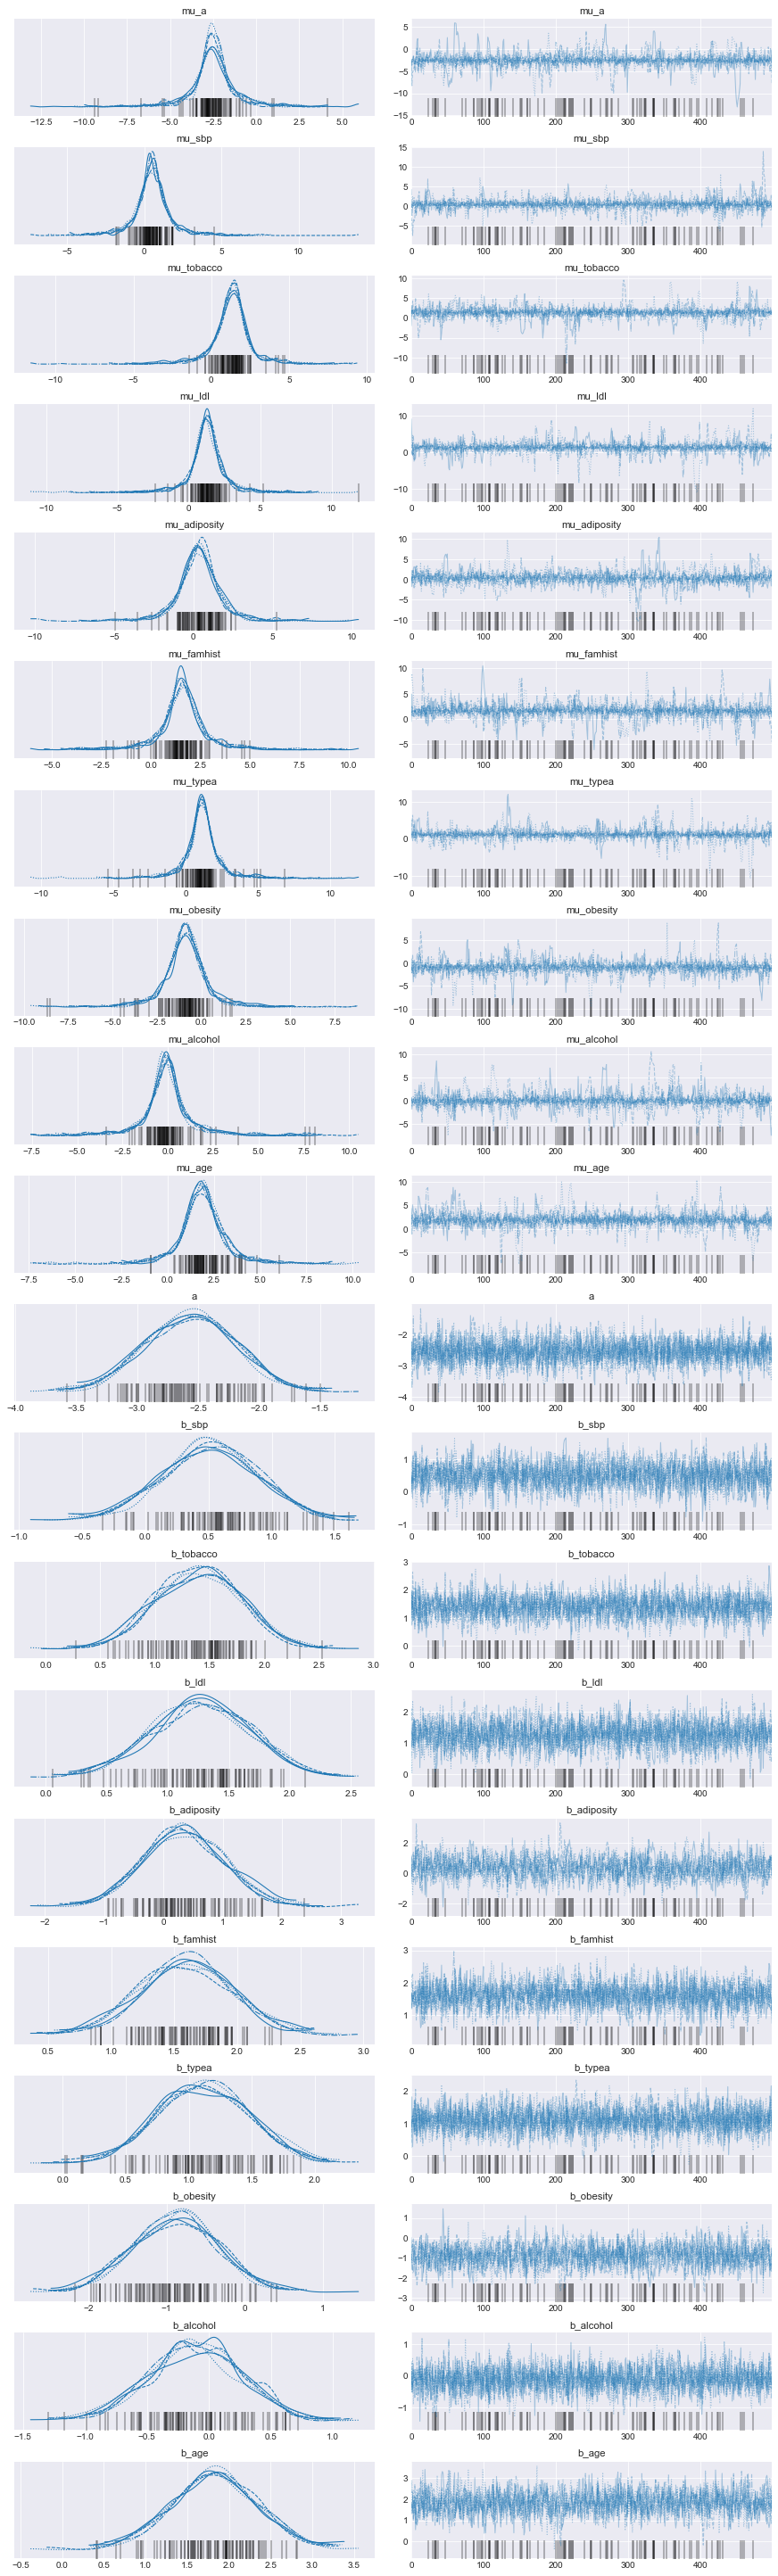

In [7]:
with varying_logOdds:
    pm.traceplot(varying_logOdds_trace)

The trace plot above shows you the distributioons made throughout the process, in which we can see if they converged or not. In these plots, they seems to converge. 

In [8]:
var_n =['a','b_sbp','b_tobacco','b_ldl','b_adiposity','b_famhist','b_typea','b_obesity','b_alcohol', 'b_age']


<Figure size 432x1296 with 0 Axes>

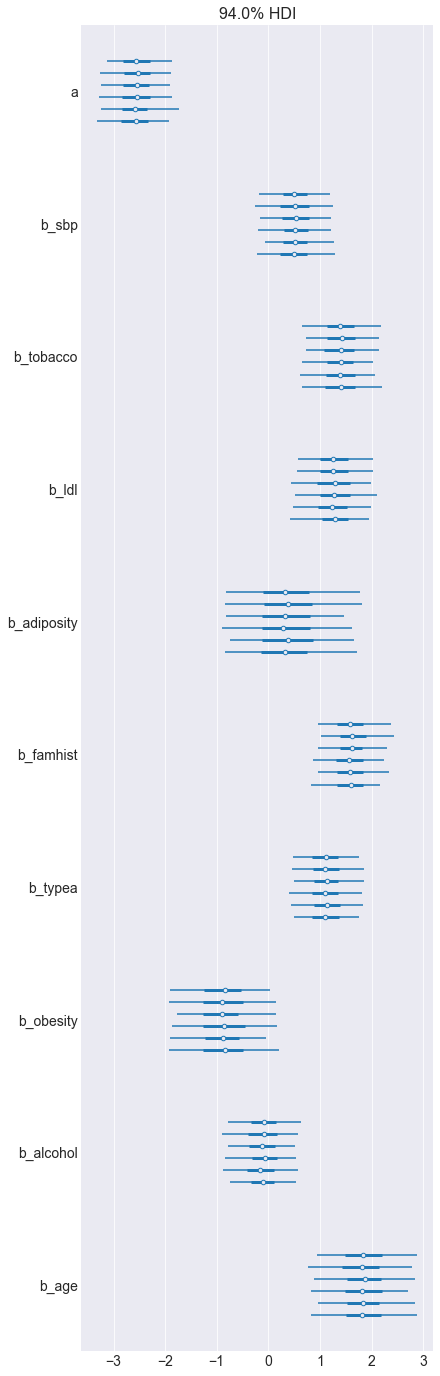

In [9]:
with varying_logOdds:
    pp.figure(figsize=(6,18))
    pm.forestplot(varying_logOdds_trace, var_names=var_n);

Based on these plots, I concluded that the predictors except sbp, adiposity, obesity, and alcohol are more useful. I may benefit from including only the predictors that are not sbp, adiposity, obesity, and alcohol. Especially, alcohol and adiposity do not seem promising. 

For the CHD data develop two models with fewer
predictor variables and/or with a nonlinear transformation of one of the
the predictor variables.


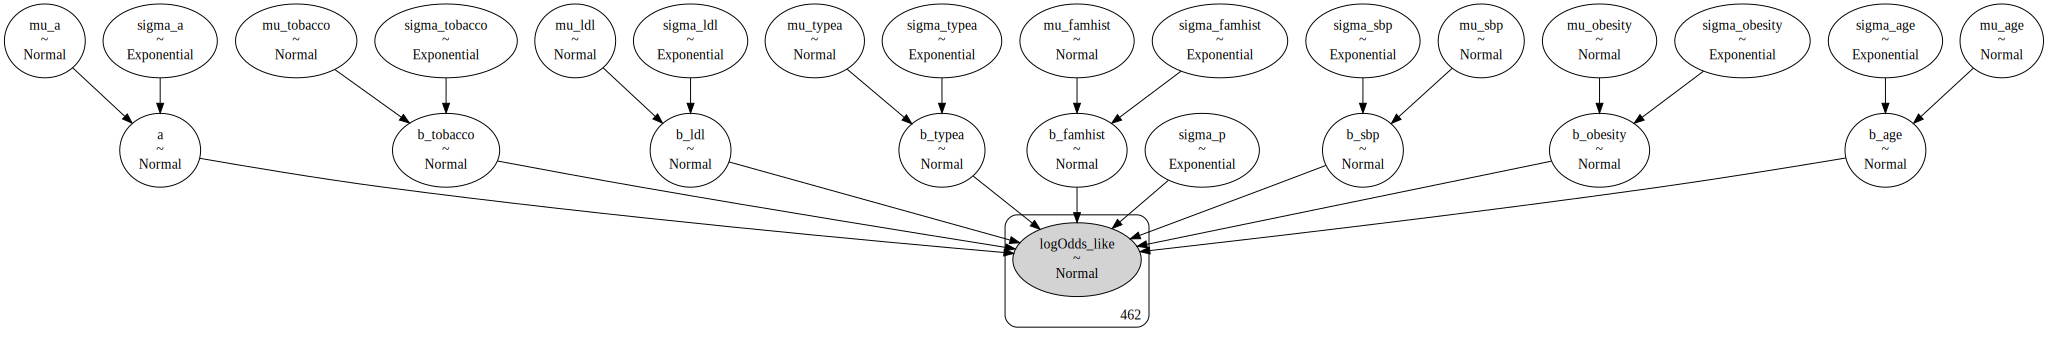

In [10]:
with Model() as varying_logOdds2:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=9999)
    sigma_a = pm.Exponential("sigma_a", 1)
    
    mu_sbp = pm.Normal('mu_sbp', mu=0, sd=9999)
    sigma_sbp = pm.Exponential("sigma_sbp", 1)
    
    mu_tobacco = pm.Normal('mu_tobacco', mu=0, sd=9999)
    sigma_tobacco = pm.Exponential("sigma_tobacco", 1)
    
    mu_ldl = pm.Normal('mu_ldl', mu=0, sd=9999)
    sigma_ldl = pm.Exponential("sigma_ldl", 1)
    
    mu_famhist = pm.Normal('mu_famhist', mu=0, sd=9999)
    sigma_famhist = pm.Exponential("sigma_famhist", 1)
    
    mu_typea = pm.Normal('mu_typea', mu=0, sd=9999)
    sigma_typea = pm.Exponential("sigma_typea", 1)
    
    mu_obesity = pm.Normal('mu_obesity', mu=0, sd=9999)
    sigma_obesity = pm.Exponential("sigma_obesity", 1)
    
    mu_age = pm.Normal('mu_age', mu=0, sd=9999)
    sigma_age = pm.Exponential("sigma_age", 1)
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a)
    # Random slopes
    b_sbp = pm.Normal('b_sbp', mu=mu_sbp, sd=sigma_sbp)
    b_tobacco = pm.Normal('b_tobacco', mu=mu_tobacco, sd=sigma_tobacco)
    b_ldl = pm.Normal('b_ldl', mu=mu_ldl, sd=sigma_ldl)
    b_famhist = pm.Normal('b_famhist', mu=mu_famhist, sd=sigma_famhist)
    b_typea = pm.Normal('b_typea', mu=mu_typea, sd=sigma_typea)
    b_obesity = pm.Normal('b_obesity', mu=mu_obesity, sd=sigma_obesity)
    b_age = pm.Normal('b_age', mu=mu_age, sd=sigma_age)
    
    # Expected value
    logOdds_hat = a + b_sbp * data_c.sbp.values + b_tobacco * data_c.tobacco.values + b_ldl * data_c.ldl.values + b_famhist * data_c.famhist.values + b_typea * data_c.typea.values + b_obesity * data_c.obesity.values + b_age * data_c.age.values
    
    sigma_p = pm.Exponential("sigma_p", 1)
    logOdds_true = tt.log(data_c.chd.values / (1 - data_c.chd.values))
    
    # Data likelihood
    logOdds_like = pm.Normal('logOdds_like', mu=logOdds_hat, sd=sigma_p, observed=logOdds_true)
pm.model_to_graphviz(varying_logOdds2)

In [11]:
with varying_logOdds2:
    varying_logOdds2_trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_p, b_age, b_obesity, b_typea, b_famhist, b_ldl, b_tobacco, b_sbp, a, sigma_age, mu_age, sigma_obesity, mu_obesity, sigma_typea, mu_typea, sigma_famhist, mu_famhist, sigma_ldl, mu_ldl, sigma_tobacco, mu_tobacco, sigma_sbp, mu_sbp, sigma_a, mu_a]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 1129 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.878610922734574, but should be close to 0.99. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


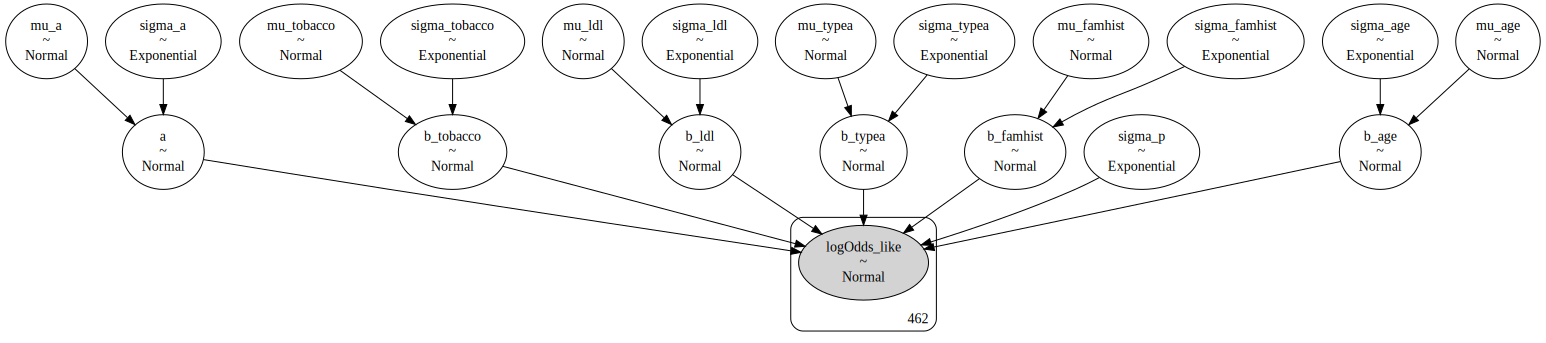

In [12]:
with Model() as varying_logOdds3:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=9999)
    sigma_a = pm.Exponential("sigma_a", 1)
    
    mu_tobacco = pm.Normal('mu_tobacco', mu=0, sd=9999)
    sigma_tobacco = pm.Exponential("sigma_tobacco", 1)
    
    mu_ldl = pm.Normal('mu_ldl', mu=0, sd=9999)
    sigma_ldl = pm.Exponential("sigma_ldl", 1)
    
    mu_famhist = pm.Normal('mu_famhist', mu=0, sd=9999)
    sigma_famhist = pm.Exponential("sigma_famhist", 1)
    
    mu_typea = pm.Normal('mu_typea', mu=0, sd=9999)
    sigma_typea = pm.Exponential("sigma_typea", 1)
    
    mu_age = pm.Normal('mu_age', mu=0, sd=9999)
    sigma_age = pm.Exponential("sigma_age", 1)
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a)
    # Random slopes
    b_tobacco = pm.Normal('b_tobacco', mu=mu_tobacco, sd=sigma_tobacco)
    b_ldl = pm.Normal('b_ldl', mu=mu_ldl, sd=sigma_ldl)
    b_famhist = pm.Normal('b_famhist', mu=mu_famhist, sd=sigma_famhist)
    b_typea = pm.Normal('b_typea', mu=mu_typea, sd=sigma_typea)
    b_age = pm.Normal('b_age', mu=mu_age, sd=sigma_age)
    
    # Expected value
    logOdds_hat = a + b_tobacco * data_c.tobacco.values + b_ldl * data_c.ldl.values + b_famhist * data_c.famhist.values + b_typea * data_c.typea.values + b_age * data_c.age.values
    
    sigma_p = pm.Exponential("sigma_p", 1)
    logOdds_true = tt.log(data_c.chd.values / (1 - data_c.chd.values))
    
    # Data likelihood
    logOdds_like = pm.Normal('logOdds_like', mu=logOdds_hat, sd=sigma_p, observed=logOdds_true)
pm.model_to_graphviz(varying_logOdds3)

In [13]:
with varying_logOdds3:
    varying_logOdds3_trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_p, b_age, b_typea, b_famhist, b_ldl, b_tobacco, a, sigma_age, mu_age, sigma_typea, mu_typea, sigma_famhist, mu_famhist, sigma_ldl, mu_ldl, sigma_tobacco, mu_tobacco, sigma_a, mu_a]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 728 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [14]:
with varying_logOdds:
    waic1 = az.waic(varying_logOdds_trace)
waic1

Computed from 3000 by 462 log-likelihood matrix

          Estimate       SE
elpd_waic -1607.30    11.24
p_waic       10.83        -

In [15]:
with varying_logOdds2:
    waic2 = az.waic(varying_logOdds2_trace)
waic2

Computed from 3000 by 462 log-likelihood matrix

          Estimate       SE
elpd_waic -1605.73    11.15
p_waic        9.07        -

In [16]:
with varying_logOdds3:
    waic3 = az.waic(varying_logOdds3_trace)
waic3

Computed from 3000 by 462 log-likelihood matrix

          Estimate       SE
elpd_waic -1605.16    11.01
p_waic        6.37        -

• Use WAIC to recommend which of these models to use

Based on the minimum WAIC score, the first model (varying_logOdds) with all predictors is actually recommended. However, since the difference is small, I would like to use the one with minimum number of predictors.

• Use WAIC to produce a Bayesian model average result. Show the
kernel density plots for the sample posterior predictions of each of
the models and the Bayesian model average.

In [17]:
import math
waic_star = -1607.48
dk1 = -1607.48 - waic_star
w1_0 = math.exp(-1/2*dk1)
dk2 = -1605.29 - waic_star
w2_0 = math.exp(-1/2*dk2)
dk3 = -1605.12 - waic_star
w3_0 = math.exp(-1/2*dk3)
den = w1_0 + w2_0 + w3_0

w1 = w1_0/den
w2 = w2_0/den
w3 = w3_0/den

• Use WAIC to produce a Bayesian model average result. Show the
kernel density plots for the sample posterior predictions of each of
the models and the Bayesian model average.


In [18]:
y_1 = pm.sample_posterior_predictive_w(traces = [varying_logOdds_trace],
                                        samples=500,
                                        models=[ varying_logOdds])
y_2 = pm.sample_posterior_predictive_w(traces = [varying_logOdds2_trace],
                                        samples=500,
                                        models=[ varying_logOdds2])
y_3 = pm.sample_posterior_predictive_w(traces = [varying_logOdds3_trace],
                                        samples=500,
                                        models=[ varying_logOdds3])

In [19]:
weights = [w1, w2, w3]
y_bma = pm.sample_posterior_predictive_w(traces = [varying_logOdds_trace, varying_logOdds2_trace, varying_logOdds3_trace],
                                        samples=500,
                                        models=[varying_logOdds, varying_logOdds2, varying_logOdds3],
                                        weights=weights)

In [20]:
y_1.keys()

dict_keys(['logOdds_like'])

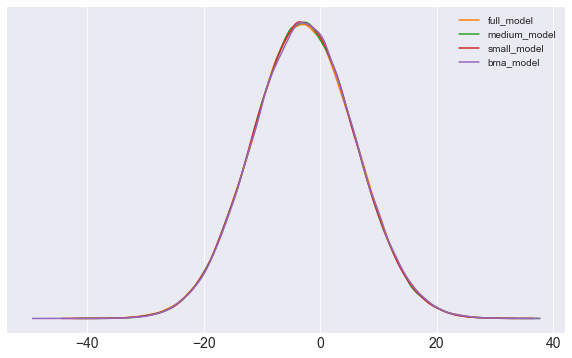

In [21]:
_, ax = pp.subplots(figsize=(10, 6))
az.plot_kde(y_1['logOdds_like'], plot_kwargs={'color': 'C1'}, label='full_model', ax=ax)
az.plot_kde(y_2['logOdds_like'], plot_kwargs={'color': 'C2'}, label='medium_model', ax=ax)
az.plot_kde(y_3['logOdds_like'], plot_kwargs={'color': 'C3'}, label='small_model', ax=ax)
az.plot_kde(y_bma['logOdds_like'], plot_kwargs={'color': 'C4'}, label='bma_model', ax=ax)

pp.yticks([])
pp.legend()

As expected, the models without the averaging or some of the predictors that are considered not useful performed similarly. Thus, I would like to use the one with minimum number of predictors 

Show the overlaid plots of the predictions for
the data points in the CHDdata.csv file with age on the x-axis and
the predicted probability on the y-axis. Overlay these results for each
model and for the Bayesian model average of the models.

In [22]:
s1 = pd.DataFrame([[varying_logOdds_trace['b_sbp'].mean()], 
                     [varying_logOdds_trace['b_tobacco'].mean()], 
                     [varying_logOdds_trace['b_ldl'].mean()], 
                     [varying_logOdds_trace['b_adiposity'].mean()], 
                     [varying_logOdds_trace['b_obesity'].mean()], 
                     [varying_logOdds_trace['b_alcohol'].mean()],  
                     [varying_logOdds_trace['b_famhist'].mean()], 
                     [varying_logOdds_trace['b_typea'].mean()], 
                     [varying_logOdds_trace['b_age'].mean()]])

s2 = pd.DataFrame([[varying_logOdds_trace['b_sbp'].mean()], 
                     [varying_logOdds_trace['b_tobacco'].mean()], 
                     [varying_logOdds_trace['b_ldl'].mean()], 
                     [varying_logOdds_trace['b_obesity'].mean()], 
                     [varying_logOdds_trace['b_famhist'].mean()], 
                     [varying_logOdds_trace['b_typea'].mean()], 
                     [varying_logOdds_trace['b_age'].mean()]])

s3 = pd.DataFrame([[varying_logOdds_trace['b_tobacco'].mean()], 
                     [varying_logOdds_trace['b_ldl'].mean()],
                     [varying_logOdds_trace['b_famhist'].mean()], 
                     [varying_logOdds_trace['b_typea'].mean()], 
                     [varying_logOdds_trace['b_age'].mean()]])

In [23]:
fakeDat1 = []
fakeDat2 = []
fakeDat3 = []
ageFake = []
for i in ['sbp', 'tobacco', 'ldl', 'adiposity', 'obesity','alcohol', 'famhist', 'typea', 'age'] :
    x_new = np.linspace(data_c[i].min(),data_c[i].max(), 100)
    fakeDat1.append(x_new)
    if i not in ['alcohol', 'adiposity'] :
        fakeDat2.append(x_new)
    if i not in ['alcohol', 'adiposity', 'obesity', 'sbp']:
        fakeDat3.append(x_new)
    if i is 'age' :
        ageFake.append(x_new)
    
fakeDF1 = pd.DataFrame(fakeDat1).T
fakeDF2 = pd.DataFrame(fakeDat2).T
fakeDF3 = pd.DataFrame(fakeDat3).T

In [24]:
y1 = fakeDF1.dot(s1)
y2 = fakeDF2.dot(s2)
y3 = fakeDF3.dot(s3)

In [25]:
pd.DataFrame(ageFake).T.shape

(100, 1)

In [26]:
y1.shape

(100, 1)

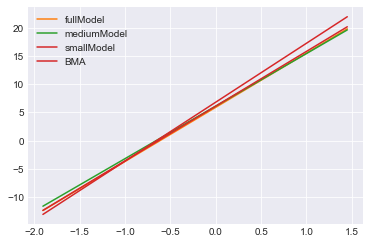

In [27]:
#Plot of both models
pp.plot(pd.DataFrame(ageFake).T[0], y1[0], 'C1', label='fullModel')
pp.plot(pd.DataFrame(ageFake).T[0], y2[0], 'C2', label='mediumModel')
pp.plot(pd.DataFrame(ageFake).T[0], y3[0], 'C3', label='smallModel')

y_bma = w1*y1 + w2*y2 + w3*y3

pp.plot(pd.DataFrame(ageFake).T[0], y_bma[0], c = 'C3', label='BMA')
pp.legend()
pp.show()

